Conexión y AOIs

In [2]:
import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
import openeo
from datetime import date

# 1) Conexión (punto 1 del PDF)
connection = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()

Authenticated using refresh token.


 2) AOIs del PDF

In [3]:
lago_atitlan = {"west": -91.326256, "east": -91.07151, "south": 14.5948,  "north": 14.750979}
lago_amatitlan = {"west": -90.638065, "east": -90.512924, "south": 14.412347, "north": 14.493799}

 3) Fechas (>= 6 meses, usar baja nubosidad)


In [4]:
good_dates = [
"2025-02-07","2025-02-10","2025-02-25","2025-02-27","2025-03-02","2025-03-04","2025-03-07","2025-03-09",
"2025-03-12","2025-03-14","2025-03-19","2025-03-22","2025-03-24","2025-03-26","2025-04-03","2025-04-11",
"2025-04-13","2025-04-15","2025-04-16","2025-04-18","2025-04-28","2025-05-03","2025-05-13","2025-05-28",
"2025-07-10","2025-07-17","2025-07-20","2025-07-24","2025-08-01"
]

In [5]:

BANDS = ["B02","B03","B04","B05","B08"]  # + B05 para NDCI

def download_s2(lake_name, bbox, d):
    out = f"data/{lake_name}_{d}.tif"
    if os.path.exists(out):
        return out
    cube = connection.load_collection(
        "SENTINEL2_L2A",
        spatial_extent=bbox,
        temporal_extent=[d, d],
        bands=BANDS
    )
    res = cube.save_result(format="GTIFF")
    job = connection.create_job(res)
    job.start_and_wait()
    os.makedirs("data", exist_ok=True)
    job.download_results(out)
    return out

def normalize(b, nodata):
    b = b.astype(np.float32)
    mask = np.ones_like(b, bool) if nodata is None else (b != nodata)
    if not np.any(mask): return np.zeros_like(b, np.float32)
    lo, hi = np.percentile(b[mask], (2, 98))
    return np.clip((b - lo) / (hi - lo + 1e-6), 0, 1)

def read_bands(path):
    with rasterio.open(path) as src:
        arr = src.read()     # 0:B02 1:B03 2:B04 3:B05 4:B08
        nod = src.nodata
    return arr, nod

def compute_indices(arr):
    B02, B03, B04, B05, B08 = arr
    # escala a reflectancia si viene en entero
    if B04.dtype != np.float32 and B04.max() > 1.5:
        B02 = B02.astype(np.float32)/10000; B03 = B03.astype(np.float32)/10000
        B04 = B04.astype(np.float32)/10000; B05 = B05.astype(np.float32)/10000; B08 = B08.astype(np.float32)/10000
    # índices (punto 5→numpy y 8→correlación NDVI/NDWI) :contentReference[oaicite:7]{index=7}
    ndvi = np.where((B08+B04)==0, np.nan, (B08-B04)/(B08+B04))
    ndwi = np.where((B03+B08)==0, np.nan, (B03-B08)/(B03+B08))
    ndci = np.where((B05+B04)==0, np.nan, (B05-B04)/(B05+B04))  # índice de cianobacteria
    return ndvi, ndwi, ndci

def show_true_color(arr, nodata, title):
    B02, B03, B04, *_ = arr
    rgb = np.dstack([normalize(B04, nodata), normalize(B03, nodata), normalize(B02, nodata)])
    plt.figure(figsize=(7,5)); plt.imshow(rgb); plt.title(title); plt.axis('off'); plt.show()

=== 4) DESCARGA y 5) Numpy ===

0:00:00 Job 'j-2508120453574701a4fd7c1d16e25008': send 'start'
0:00:13 Job 'j-2508120453574701a4fd7c1d16e25008': queued (progress 0%)
0:00:18 Job 'j-2508120453574701a4fd7c1d16e25008': queued (progress 0%)
0:00:25 Job 'j-2508120453574701a4fd7c1d16e25008': queued (progress 0%)
0:00:33 Job 'j-2508120453574701a4fd7c1d16e25008': queued (progress 0%)
0:00:43 Job 'j-2508120453574701a4fd7c1d16e25008': queued (progress 0%)
0:00:56 Job 'j-2508120453574701a4fd7c1d16e25008': queued (progress 0%)
0:01:11 Job 'j-2508120453574701a4fd7c1d16e25008': running (progress N/A)
0:01:31 Job 'j-2508120453574701a4fd7c1d16e25008': running (progress N/A)
0:01:55 Job 'j-2508120453574701a4fd7c1d16e25008': running (progress N/A)
0:02:25 Job 'j-2508120453574701a4fd7c1d16e25008': finished (progress 100%)


C:\Users\diego\AppData\Local\Temp\ipykernel_30040\413557691.py:17: UserDeprecationWarning: Call to deprecated method download_results. (Instead use `BatchJob.get_results` and the more flexible download functionality of `JobResults`) -- Deprecated since version 0.4.10.
  job.download_results(out)
C:\Users\diego\AppData\Local\Temp\ipykernel_30040\413557691.py:40: RuntimeWarning: divide by zero encountered in divide
  ndvi = np.where((B08+B04)==0, np.nan, (B08-B04)/(B08+B04))
C:\Users\diego\AppData\Local\Temp\ipykernel_30040\413557691.py:40: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where((B08+B04)==0, np.nan, (B08-B04)/(B08+B04))
C:\Users\diego\AppData\Local\Temp\ipykernel_30040\413557691.py:41: RuntimeWarning: divide by zero encountered in divide
  ndwi = np.where((B03+B08)==0, np.nan, (B03-B08)/(B03+B08))
C:\Users\diego\AppData\Local\Temp\ipykernel_30040\413557691.py:41: RuntimeWarning: invalid value encountered in divide
  ndwi = np.where((B03+B08)==0, np.nan, (B

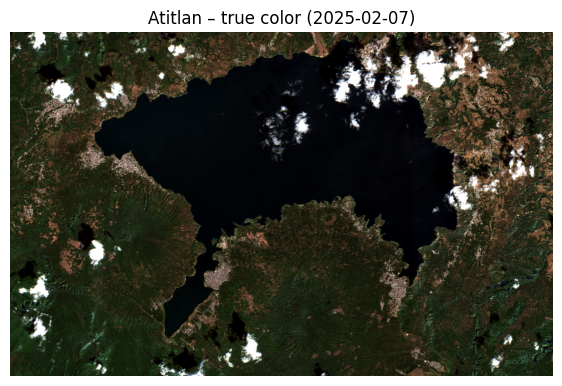

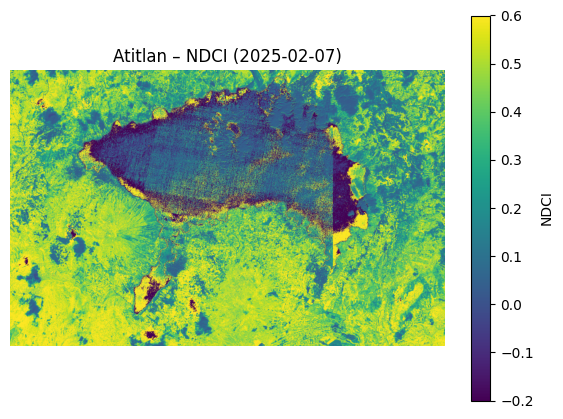

0:00:00 Job 'j-2508120457554e0e8136dfeb00657a27': send 'start'
0:00:13 Job 'j-2508120457554e0e8136dfeb00657a27': created (progress 0%)
0:00:19 Job 'j-2508120457554e0e8136dfeb00657a27': queued (progress 0%)
0:00:25 Job 'j-2508120457554e0e8136dfeb00657a27': queued (progress 0%)
0:00:33 Job 'j-2508120457554e0e8136dfeb00657a27': queued (progress 0%)
0:00:44 Job 'j-2508120457554e0e8136dfeb00657a27': queued (progress 0%)
0:00:56 Job 'j-2508120457554e0e8136dfeb00657a27': queued (progress 0%)
0:01:12 Job 'j-2508120457554e0e8136dfeb00657a27': queued (progress 0%)
0:01:31 Job 'j-2508120457554e0e8136dfeb00657a27': queued (progress 0%)
0:01:55 Job 'j-2508120457554e0e8136dfeb00657a27': queued (progress 0%)
0:02:26 Job 'j-2508120457554e0e8136dfeb00657a27': queued (progress 0%)
0:03:03 Job 'j-2508120457554e0e8136dfeb00657a27': queued (progress 0%)
0:03:50 Job 'j-2508120457554e0e8136dfeb00657a27': running (progress N/A)
0:04:49 Job 'j-2508120457554e0e8136dfeb00657a27': finished (progress 100%)
0:00:00

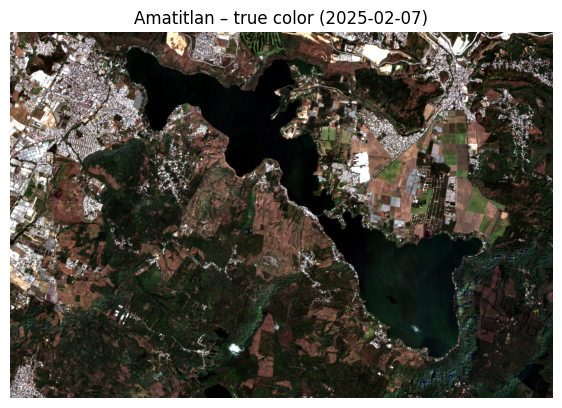

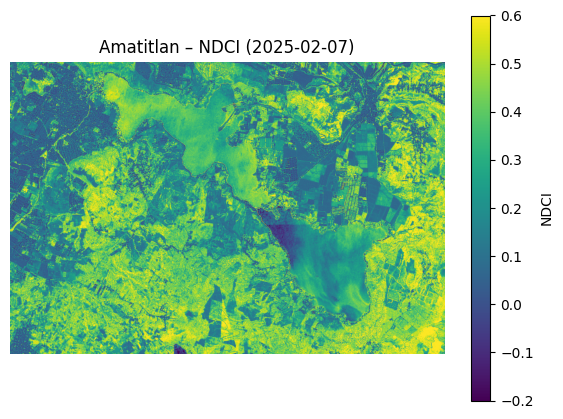

0:00:00 Job 'j-250812064243402a856c6814e9793a67': send 'start'
0:00:13 Job 'j-250812064243402a856c6814e9793a67': created (progress 0%)
0:00:18 Job 'j-250812064243402a856c6814e9793a67': created (progress 0%)
0:00:25 Job 'j-250812064243402a856c6814e9793a67': running (progress N/A)
0:00:33 Job 'j-250812064243402a856c6814e9793a67': running (progress N/A)
0:00:43 Job 'j-250812064243402a856c6814e9793a67': running (progress N/A)
0:00:56 Job 'j-250812064243402a856c6814e9793a67': running (progress N/A)
0:01:11 Job 'j-250812064243402a856c6814e9793a67': running (progress N/A)
0:01:31 Job 'j-250812064243402a856c6814e9793a67': error (progress N/A)
Your batch job 'j-250812064243402a856c6814e9793a67' failed. Error logs:
[{'id': '[1754981017626, 855373]', 'time': '2025-08-12T06:43:37.626Z', 'level': 'error', 'message': 'create_pyramid failed: Could not find data for your load_collection request with catalog ID "Sentinel2". The catalog query had correlation ID "j-250812064243402a856c6814e9793a67" and r

In [13]:
def process_lake(lake_name, bbox):
    rows = []
    for d in good_dates:
        try:
            tif = download_s2(lake_name, bbox, d)  # puntos 1–2–3–4–5 del PDF
            arr, nod = read_bands(tif)
            ndvi, ndwi, ndci = compute_indices(arr)
            # guarda métricas promedio (punto 6.1)
            rows.append({"date": d,
                         "ndvi_mean": np.nanmean(ndvi),
                         "ndwi_mean": np.nanmean(ndwi),
                         "ndci_mean": np.nanmean(ndci)})
            # primer render por lago (true color)
            if d == good_dates[0]:
                show_true_color(arr, nod, f"{lake_name.capitalize()} – true color ({d})")
                plt.figure(figsize=(7,5)); plt.imshow(ndci, cmap="viridis", vmin=-0.2, vmax=0.6)
                plt.colorbar(label="NDCI"); plt.title(f"{lake_name.capitalize()} – NDCI ({d})")
                plt.axis('off'); plt.show()
        except Exception as e:
            print("Saltando", lake_name, d, e)
    return pd.DataFrame(rows).sort_values("date")

ts_atitlan   = process_lake("atitlan",   lago_atitlan)
ts_amatitlan = process_lake("amatitlan", lago_amatitlan)

In [6]:
from datetime import datetime, timedelta
import glob, re

def existing_dates(lake_name):
    files = glob.glob(f"data/{lake_name}_*.tif")
    got = set()
    for f in files:
        m = re.search(rf"{lake_name}_(\d{{4}}-\d{{2}}-\d{{2}})\.tif$", f)
        if m: got.add(m.group(1))
    return got

missing_atitlan   = [d for d in good_dates if d not in existing_dates("atitlan")]
missing_amatitlan = [d for d in good_dates if d not in existing_dates("amatitlan")]

print("Faltan Atitlán:", missing_atitlan)
print("Faltan Amatitlán:", missing_amatitlan)


Faltan Atitlán: []
Faltan Amatitlán: ['2025-02-10', '2025-02-25', '2025-03-02', '2025-03-07', '2025-03-12', '2025-03-22', '2025-04-11', '2025-04-16', '2025-07-10', '2025-07-20']


#### Intentar descargar los faltantes

In [1]:
# def fill_missing(lake_name, bbox, missing_dates):
#     ok, bad = [], []
#     for d in missing_dates:
#         p = download_s2(lake_name, bbox, d)  
#         if p: ok.append(d)
#         else: bad.append(d)
#     print(f"{lake_name}: recuperadas {len(ok)}, no logradas {len(bad)} ->", bad)
#     return ok, bad
#
# fill_missing("amatitlan", lago_amatitlan, missing_amatitlan)


Se intento ejecutar este codigo el cual dio error, entonces verificamos los datos y nos fuimos a verificarlos manualmente en copernicus y efectivamente para esos dias que no se descargaron es porque no existen datos para esos dias asi que trabajaremos con los que logramos descargar. 

3) Cálculo de índices (NDVI, NDWI, NDCI) + Chl-a y máscara de agua

Fórmulas (Sentinel-2):

    NDVI = (B08 − B04) / (B08 + B04)

    NDWI = (B03 − B08) / (B03 + B08)

    NDCI = (B05 − B04) / (B05 + B04) ← clorofila en aguas turbias (roja vs red-edge).
    Sentinel Hub custom scripts

    El evalscript del link también usa FAI con (B04, B07, B8A) y una máscara de agua basada en MNDWI/NDWI/AWEI, útil para excluir tierra/urbano.
    Sentinel Hub custom scripts

4) Estadísticos por fecha y lago (serie temporal)

Graficar evolución temporal : medias de NDCI y Chl-a por lago, + marcar picos.